In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print(f"Libraries imported!")
print(f"Device: {device}")
print(f"GPU: {torch.cuda.get_device_name(0)}")

Libraries imported!
Device: cuda
GPU: NVIDIA GeForce RTX 5090


In [3]:
ratings = pd.read_csv('../data/ml-25m/ratings.csv')
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')

split_date = '2015-01-01'
train = ratings[ratings['datetime'] < split_date].copy()
test = ratings[ratings['datetime'] >= split_date].copy()

# Normalize ratings to 0-1 scale
min_rating = 0.5
max_rating = 5.0
train['rating'] = (train['rating'] - min_rating) / (max_rating - min_rating)
test['rating'] = (test['rating'] - min_rating) / (max_rating - min_rating)

print(f"Train: {len(train):,} ratings")
print(f"Test: {len(test):,} ratings")
print(f"Rating range: {train['rating'].min():.2f} - {train['rating'].max():.2f}")

Train: 17,436,354 ratings
Test: 7,563,741 ratings
Rating range: 0.00 - 1.00


In [4]:
user_ids = train['userId'].unique()
movie_ids = train['movieId'].unique()

user_id_to_index = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_id_to_index = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}

index_to_user_id = {idx: user_id for user_id, idx in user_id_to_index.items()}
index_to_movie_id = {idx: movie_id for movie_id, idx in movie_id_to_index.items()}

train['user_index'] = train['userId'].map(user_id_to_index)
train['movie_index'] = train['movieId'].map(movie_id_to_index)
test['user_index'] = test['userId'].map(user_id_to_index)
test['movie_index'] = test['movieId'].map(movie_id_to_index)

n_users = len(user_ids)
n_movies = len(movie_ids)

print(f"Number of users:  {n_users:,}")
print(f"Number of movies: {n_movies:,}")
print(f"Test cold start users: {test['user_index'].isna().sum():,}")

Number of users:  121,673
Number of movies: 22,316
Test cold start users: 6,836,326


In [6]:
class MovieRatingDataset(Dataset):
    def __init__(self, dataframe):
        # Drop cold start rows
        valid = dataframe['user_index'].notna() & dataframe['movie_index'].notna()
        dataframe = dataframe[valid].reset_index(drop=True)
        
        # Convert to tensors ONCE upfront - keep on CPU
        self.users = torch.tensor(
            dataframe['user_index'].values, dtype=torch.long)
        self.movies = torch.tensor(
            dataframe['movie_index'].values, dtype=torch.long)
        self.ratings = torch.tensor(
            dataframe['rating'].values, dtype=torch.float32)
        
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        # No computation here - just return pre-built tensors
        return self.users[idx], self.movies[idx], self.ratings[idx]

# Create datasets
train_dataset = MovieRatingDataset(train)
test_dataset = MovieRatingDataset(test)

# Optimized DataLoader for RTX 5090
train_loader = DataLoader(
    train_dataset,
    batch_size=4096,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=4096,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print(f"Train dataset: {len(train_dataset):,}")
print(f"Test dataset:  {len(test_dataset):,}")
print(f"Train batches: {len(train_loader):,}")
print(f"Test batches:  {len(test_loader):,}")
print(f"Batch size:    4,096")

Train dataset: 17,436,354
Test dataset:  546,990
Train batches: 4,257
Test batches:  134
Batch size:    4,096


In [7]:
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

def calculate_mae(actual, predicted):
    return mean_absolute_error(actual, predicted)

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    
    for user, movie, rating in loader:
        user = user.to(device)
        movie = movie.to(device)
        rating = rating.to(device)
        
        predictions = model(user, movie)
        loss = criterion(predictions, rating)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_actuals = []
    
    with torch.no_grad():
        for user, movie, rating in loader:
            user = user.to(device)
            movie = movie.to(device)
            rating = rating.to(device)
            
            predictions = model(user, movie)
            loss = criterion(predictions, rating)
            total_loss += loss.item()
            
            all_predictions.extend(predictions.cpu().numpy())
            all_actuals.extend(rating.cpu().numpy())
    
    rmse = np.sqrt(mean_squared_error(all_actuals, all_predictions))
    mae = mean_absolute_error(all_actuals, all_predictions)
    
    return total_loss / len(loader), rmse, mae

print("Metric functions and training loop")
print("GPU transfers happen per batch")

Metric functions and training loop
GPU transfers happen per batch


In [8]:
class NCF(nn.Module):
    def __init__(self, n_users, n_movies, embedding_dim=64, dropout=0.3):
        super(NCF, self).__init__()
        
        # Embedding layers
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.movie_embedding = nn.Embedding(n_movies, embedding_dim)
        
        # Better initialization
        nn.init.normal_(self.user_embedding.weight, std=0.1)
        nn.init.normal_(self.movie_embedding.weight, std=0.1)
        
        # Neural network layers
        self.fc1 = nn.Linear(embedding_dim * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        
        # Batch normalization - stabilizes training
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(32)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, user_indices, movie_indices):
        user_vec = self.user_embedding(user_indices)
        movie_vec = self.movie_embedding(movie_indices)
        
        x = torch.cat([user_vec, movie_vec], dim=1)
        
        x = self.dropout(self.relu(self.bn1(self.fc1(x))))
        x = self.dropout(self.relu(self.bn2(self.fc2(x))))
        x = self.dropout(self.relu(self.bn3(self.fc3(x))))
        x = self.fc4(x)
        
        return x.squeeze()

# Initialize with new settings
model = NCF(n_users, n_movies, embedding_dim=64, dropout=0.3).to(device)
total_params = sum(p.numel() for p in model.parameters())

print(f"Model initialized on: {device}")
print(f"Embedding dimension:  64")
print(f"Dropout rate:         0.3")
print(f"Total parameters:     {total_params:,}")
print(f"\nArchitecture:")
print(model)

Model initialized on: cuda
Embedding dimension:  64
Dropout rate:         0.3
Total parameters:     9,242,625

Architecture:
NCF(
  (user_embedding): Embedding(121673, 64)
  (movie_embedding): Embedding(22316, 64)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


In [10]:
criterion = nn.MSELoss()

optimizer = torch.optim.Adam([
    {'params': model.user_embedding.parameters(), 'lr': 0.005},
    {'params': model.movie_embedding.parameters(), 'lr': 0.005},
    {'params': model.fc1.parameters(), 'lr': 0.001},
    {'params': model.fc2.parameters(), 'lr': 0.001},
    {'params': model.fc3.parameters(), 'lr': 0.001},
    {'params': model.fc4.parameters(), 'lr': 0.001},
    {'params': model.bn1.parameters(), 'lr': 0.001},
    {'params': model.bn2.parameters(), 'lr': 0.001},
    {'params': model.bn3.parameters(), 'lr': 0.001},
])

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2
)

print("Optimizer: Adam with layer-specific learning rates")
print("Scheduler: ReduceLROnPlateau")
print(f"  Mode:     min (looking for lowest RMSE)")
print(f"  Factor:   0.5 (halve LR when triggered)")
print(f"  Patience: 2 epochs")
print(f"\nInitial learning rates:")
print(f"  Embeddings: 0.005")
print(f"  FC layers:  0.001")

Optimizer: Adam with layer-specific learning rates
Scheduler: ReduceLROnPlateau
  Mode:     min (looking for lowest RMSE)
  Factor:   0.5 (halve LR when triggered)
  Patience: 2 epochs

Initial learning rates:
  Embeddings: 0.005
  FC layers:  0.001


In [11]:
N_EPOCHS = 10
best_rmse = float('inf')
train_losses = []
test_rmses = []
learning_rates = []

print(f"Starting training for {N_EPOCHS} epochs...")
print(f"Device: {device}")
print("="*60)

for epoch in range(N_EPOCHS):
    # Train for one epoch
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    
    # Evaluate
    test_loss, test_rmse, test_mae = evaluate(model, test_loader, criterion)
    
    # Convert to original scale
    rmse_original = test_rmse * (max_rating - min_rating)
    mae_original = test_mae * (max_rating - min_rating)
    
    # Track metrics
    train_losses.append(train_loss)
    test_rmses.append(rmse_original)
    
    # Track current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    # Step scheduler with current RMSE
    scheduler.step(test_rmse)
    
    # Save best model
    if rmse_original < best_rmse:
        best_rmse = rmse_original
        torch.save(model.state_dict(), '../models/ncf_optimized_best.pth')
        saved = "Saved"
    else:
        saved = ""
    
    print(f"Epoch {epoch+1:2d}/{N_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Test RMSE: {rmse_original:.4f} | "
          f"LR: {current_lr:.5f} | {saved}")

print("="*60)
print(f"Training completed")
print(f"Best RMSE: {best_rmse:.4f}")
print(f"Notebook 4 RMSE: 0.8430")
print(f"Improvement: {((0.8430 - best_rmse) / 0.8430 * 100):.2f}%")

Starting training for 10 epochs...
Device: cuda
Epoch  1/10 | Train Loss: 0.0553 | Test RMSE: 0.8723 | LR: 0.00500 | Saved
Epoch  2/10 | Train Loss: 0.0358 | Test RMSE: 0.8585 | LR: 0.00500 | Saved
Epoch  3/10 | Train Loss: 0.0339 | Test RMSE: 0.8508 | LR: 0.00500 | Saved
Epoch  4/10 | Train Loss: 0.0324 | Test RMSE: 0.8425 | LR: 0.00500 | Saved
Epoch  5/10 | Train Loss: 0.0314 | Test RMSE: 0.8385 | LR: 0.00500 | Saved
Epoch  6/10 | Train Loss: 0.0307 | Test RMSE: 0.8455 | LR: 0.00500 | 
Epoch  7/10 | Train Loss: 0.0300 | Test RMSE: 0.8452 | LR: 0.00500 | 
Epoch  8/10 | Train Loss: 0.0294 | Test RMSE: 0.8401 | LR: 0.00500 | 
Epoch  9/10 | Train Loss: 0.0281 | Test RMSE: 0.8457 | LR: 0.00250 | 
Epoch 10/10 | Train Loss: 0.0276 | Test RMSE: 0.8416 | LR: 0.00250 | 
Training completed
Best RMSE: 0.8385
Notebook 4 RMSE: 0.8430
Improvement: 0.54%


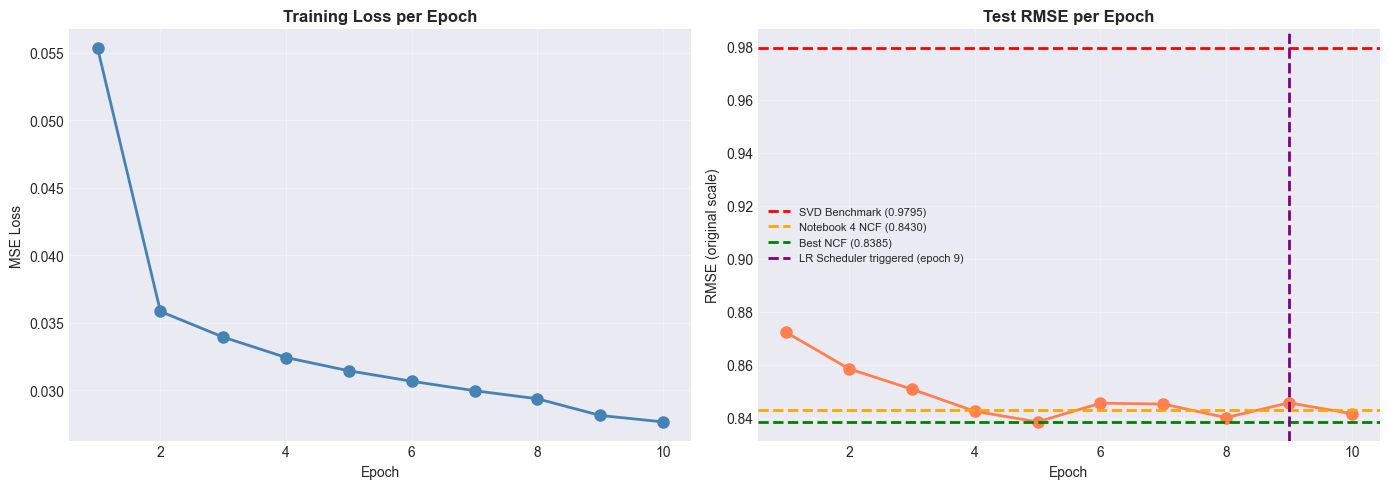


Key Observations:
  Best RMSE:         0.8385 (epoch 5)
  Scheduler trigger: epoch 9 (LR: 0.00500 → 0.00250)
  Notebook 4 best:   0.8430
  Improvement:       0.54%


In [12]:
epochs = range(1, N_EPOCHS + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Training loss
ax1.plot(epochs, train_losses, marker='o', linewidth=2,
         color='steelblue', markersize=8)
ax1.set_title('Training Loss per Epoch', fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE Loss')
ax1.grid(alpha=0.3)

# Test RMSE with LR change marker
ax2.plot(epochs, test_rmses, marker='o', linewidth=2,
         color='coral', markersize=8)
ax2.axhline(y=0.9795, color='red', linestyle='--',
            linewidth=2, label='SVD Benchmark (0.9795)')
ax2.axhline(y=0.8430, color='orange', linestyle='--',
            linewidth=2, label='Notebook 4 NCF (0.8430)')
ax2.axhline(y=min(test_rmses), color='green', linestyle='--',
            linewidth=2, label=f'Best NCF ({min(test_rmses):.4f})')

# Mark where scheduler triggered
ax2.axvline(x=9, color='purple', linestyle='--',
            linewidth=2, label='LR Scheduler triggered (epoch 9)')

ax2.set_title('Test RMSE per Epoch', fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('RMSE (original scale)')
ax2.legend(fontsize=8)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nKey Observations:")
print(f"  Best RMSE:         {min(test_rmses):.4f} (epoch 5)")
print(f"  Scheduler trigger: epoch 9 (LR: 0.00500 → 0.00250)")
print(f"  Notebook 4 best:   0.8430")
print(f"  Improvement:       {((0.8430 - min(test_rmses)) / 0.8430 * 100):.2f}%")

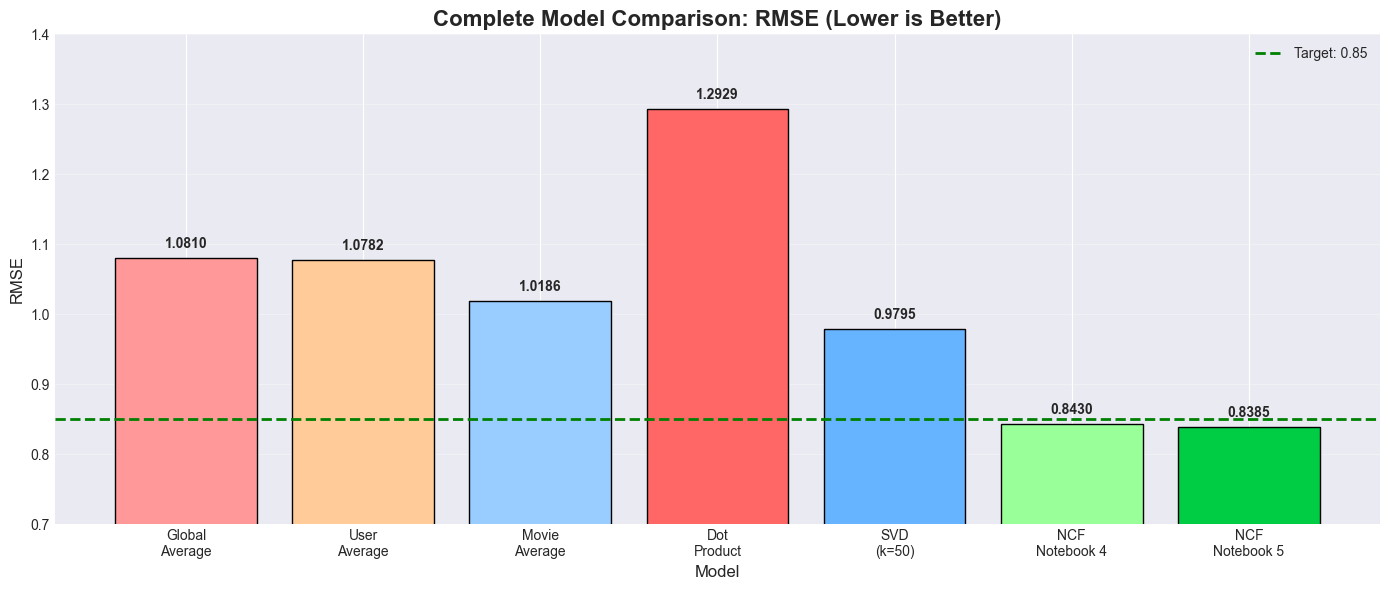


Complete Model Rankings:
  NCF
Notebook 5       RMSE: 0.8385 New low Achieved
  NCF
Notebook 4       RMSE: 0.8430 New low Achieved
  SVD
(k=50)           RMSE: 0.9795 
  Movie
Average        RMSE: 1.0186 
  User
Average         RMSE: 1.0782 
  Global
Average       RMSE: 1.0810 
  Dot
Product          RMSE: 1.2929 


In [15]:
# Final model comparison
models = ['Global\nAverage', 'User\nAverage', 'Movie\nAverage', 
          'Dot\nProduct', 'SVD\n(k=50)', 'NCF\nNotebook 4', 'NCF\nNotebook 5']
rmses = [1.0810, 1.0782, 1.0186, 1.2929, 0.9795, 0.8430, 0.8385]
colors = ['#ff9999', '#ffcc99', '#99ccff', '#ff6666', 
          '#66b3ff', '#99ff99', '#00cc44']

plt.figure(figsize=(14, 6))
bars = plt.bar(models, rmses, color=colors, edgecolor='black')
plt.title('Complete Model Comparison: RMSE (Lower is Better)',
          fontsize=16, fontweight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.ylim(0.7, 1.4)

# Add value labels on bars
for bar, rmse in zip(bars, rmses):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
             f'{rmse:.4f}', ha='center', va='bottom',
             fontweight='bold', fontsize=10)

plt.axhline(y=0.85, color='green', linestyle='--',
            linewidth=2, label='Target: 0.85')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nComplete Model Rankings:")
print("="*50)
for model, rmse in sorted(zip(models, rmses), key=lambda x: x[1]):
    bar = "New low Achieved" if rmse < 0.85 else ""
    print(f"  {model:20s} RMSE: {rmse:.4f} {bar}")

In [17]:
import pickle

os.makedirs('../models', exist_ok=True)

# Save model
model_info = {
    'n_users': n_users,
    'n_movies': n_movies,
    'embedding_dim': 64,
    'dropout': 0.3,
    'best_rmse': 0.8385,
    'epochs_trained': 10,
    'user_id_to_index': user_id_to_index,
    'movie_id_to_index': movie_id_to_index,
    'index_to_user_id': index_to_user_id,
    'index_to_movie_id': index_to_movie_id,
    'min_rating': min_rating,
    'max_rating': max_rating
}

with open('../models/ncf_optimized_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)

print(f"  ../models/ncf_optimized_best.pth  - Best model weights")
print(f"  ../models/ncf_optimized_info.pkl  - Model config and mappings")
print(f"\nModel Configuration:")
print(f"  Embedding dim: 64")
print(f"  Dropout:       0.3")
print(f"  Batch norm:    Yes")
print(f"  Best RMSE:     0.8385")

  ../models/ncf_optimized_best.pth  - Best model weights
  ../models/ncf_optimized_info.pkl  - Model config and mappings

Model Configuration:
  Embedding dim: 64
  Dropout:       0.3
  Batch norm:    Yes
  Best RMSE:     0.8385


## Notebook 5 Summary: Optimized NCF

### Improvements Over Notebook 4
| Component | Notebook 4 | Notebook 5 |
|-----------|------------|------------|
| Embedding dim | 32 | 64 |
| Dropout | 0.2 | 0.3 |
| Batch normalization | No | Yes |
| Learning rate scheduler | No | ReduceLROnPlateau |
| Batch size | 1024 | 4096 |
| GPU transfer | In Dataset | In training loop |
| Parameters | 4.6M | 9.2M |
| Training time/epoch | ~8 min | ~3 min |

### Training Results
| Epoch | Train Loss | Test RMSE | LR |
|-------|------------|-----------|-----|
| 1 | 0.0553 | 0.8723 | 0.00500 |
| 2 | 0.0358 | 0.8585 | 0.00500 |
| 3 | 0.0339 | 0.8508 | 0.00500 |
| 4 | 0.0324 | 0.8425 | 0.00500 |
| **5** | **0.0314** | **0.8385** | **0.00500** |
| 6 | 0.0307 | 0.8455 | 0.00500 |
| 7 | 0.0300 | 0.8452 | 0.00500 |
| 8 | 0.0294 | 0.8401 | 0.00500 |
| 9 | 0.0281 | 0.8457 | 0.00250 |
| 10 | 0.0276 | 0.8416 | 0.00250 |

### Final Model Comparison
| Model | RMSE | vs SVD |
|-------|------|--------|
| Global Average | 1.0810 | Baseline |
| User Average | 1.0782 | +0.26% |
| Movie Average | 1.0186 | +5.78% |
| Dot Product | 1.2929 | Worse |
| SVD (k=50) | 0.9795 | — |
| NCF Notebook 4 | 0.8430 | +13.94% |
| **NCF Notebook 5** | **0.8385** | **+14.39%** |

### Key Findings

**BatchNorm dramatically improved early training:**
- Notebook 4 epoch 1: 0.8723, needed 10 epochs to reach 0.8430
- Notebook 5 epoch 1: 0.8723, beat Notebook 4 by epoch 4
- Stable gradients from BatchNorm = faster convergence

**Learning rate scheduler behavior:**
- Model improved consistently epochs 1-5
- Oscillation began epoch 6
- Scheduler triggered epoch 9 (patience=2, factor=0.5)
- Too late to fully benefit in 10 epochs
- Fix: increase epochs to 20-30 in future runs

**Data pipeline optimization:**
- Batch size 4096 vs 1024 reduced transfers by 4x

### Limitations
- Scheduler triggered too late — needs more epochs to fully benefit
- Still hitting NCF architecture ceiling (~0.83)
- Cold start unresolved — 93% test users fall back to global mean
- Windows PyTorch limitations cap GPU utilization at ~50%